## Things I learned/ worth remembering
- Debayering does not decrease the number of pixels --> always assumed it was a fancy way of making the pixels overlap each other so that effective nr of pixels is 4xactual pixels
- Preprocessing of exposure time is very odd -- is this some global property?
- HDR is not worth implementing for this but we can use it to estimate sensor spectral response : Maybe 
- ISP applies contrast correction using a gamma curve (ie non linear response built in) --> Nonelinear response to photon input
    - This is on top of the spectral response (and most likely factors into it with blacklevels and general preprocessing) 
- Spectroscope has large respnse in uv but strongest in second diffraction
    - Det from UV lamp that according to dissatisfied customer review is 390nm/400nm central

- Fisheye lens correction:
    Find wall with equiv grid, use opencv to determine lens distortion at several points and project to equal area azi rather than planar




In [4]:
# First we calibrate against the Baader filter to get an approximate idea of how x is scaled
%load_ext autoreload
%autoreload 2
from calibrate import *
import matplotlib.pyplot as plt
import numpy as np
import skimage

## TODO
Dark calibration needs to work for all exposure lengths
- Write interpolation

Second diffraction spectrum overlaping nir, find beginning of second and of zeroth in image

At some point get to this: HDR like imaging to determine lower responses -> figure out how to measure spilling (possibly very dark source directly in fornt of spectrometer -> But need very good calibration and resolution for this)

# Basic Lens and Noise Calibration
In this section the following calibrations are found within the Calibration class
- Bias
- Dark # TODO: on final set up
- Flat # TODO: on final set up
- Lens distortion
- Rotation
- Crop bounds

## Note that all calib images need to be recomputed using the custom debayering

Calibration class will eventually hold all relevant data

In [5]:
cal_dir = '/home/felix/KID_scripts/Spectroscope/cal_images'
cal = Calibration(cal_directory=cal_dir)

In [43]:
#   Only run this to generate new data takes 
# ~ 50s without Darks prob 70 with
im = cal.run_all_calibration(bias_img_dir='./cal_images/Bias/',
                        dark_img_dir=None,
                        lens_img_dir='./cal_images/Lens_distortion',
                        flat_img_dir=None,#'./cal_images/Flats',
                        rot='./cal_images/baader_filter/no_filter',
                        crop=True,
                        # Below to be updated once calib complete
                        px_to_lambda=[-5.81921185e-07,  1.26781012e-03, -2.31237841e-01,  2.51231630e+02])

Compute lens calibration --> Code should be double checked for new calibration data


In [6]:
#    If calibration was already done 
# Load the data
cal.load_calibration(cal_path=None) # None loads default location
cal.calib

{'mbias': '/home/felix/KID_scripts/Spectroscope/cal_images/computed_cal_files/master_bias.npy',
 'px_to_lambda': [-3.53463634e-07, 0.000757740053, 0.096802281, 196.536671],
 'mdark': None,
 'mflat': None,
 'mtx': [[77.68756660884115, 0.0, 1295.5],
  [0.0, 44.56274942463647, 971.5],
  [0.0, 0.0, 1.0]],
 'dist': [[-7.655316929042589e-15,
   -3.953874556280091e-10,
   9.552922808231535e-17,
   -4.648298203300493e-17,
   2.5723372316121737e-15]],
 'Rotation': 1.9688423049240917,
 'Crop_y': [720, 1132]}

TypeError: expected str, bytes or os.PathLike object, not NoneType

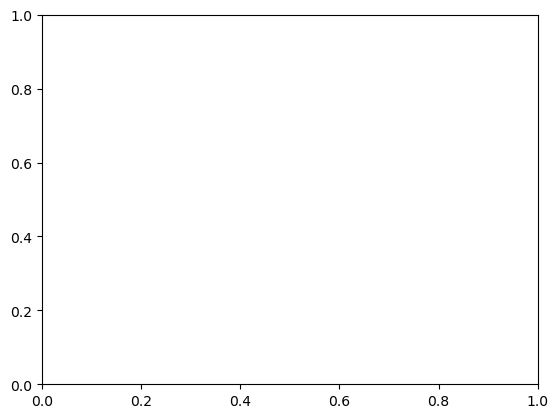

In [8]:
# Flat
fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(np.load(cal.calib['mflat']))
print('max: {}, min:{}'.format(np.load(cal.calib['mflat']).max(),np.load(cal.calib['mflat']).min()))
plt.title('Master Flat')

max: 1368.9292929292928, min:720.3535353535353
mean:992.054510555594
Below was relevant for ISP preprocessed sensor data, if the two arent equal the camerea is doing preprocessing
Px with bias: 15116544 out of 15116544


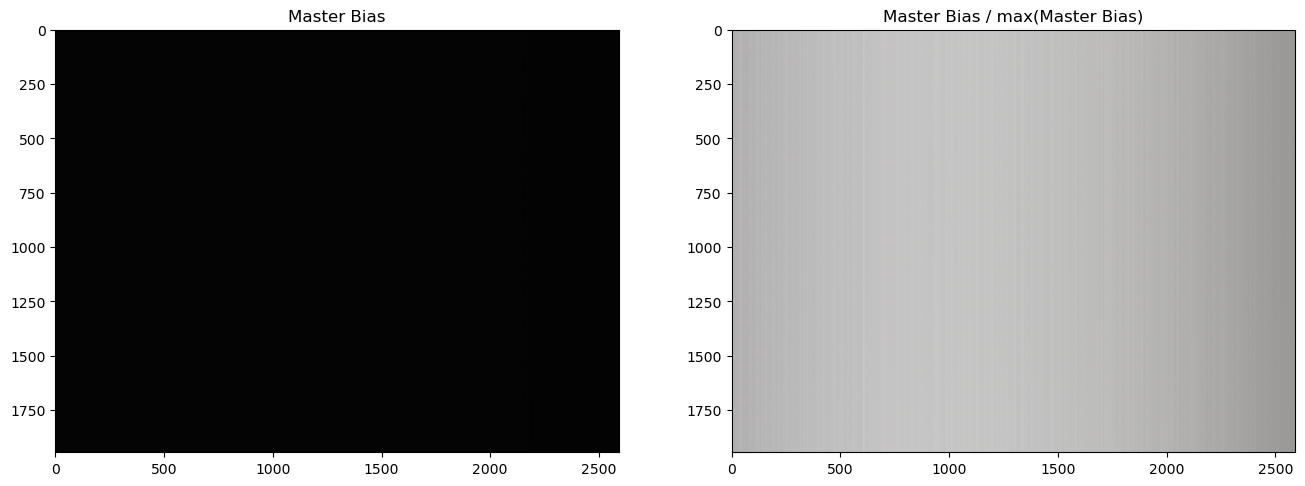

In [14]:
# Bias
fig = plt.figure(figsize=(16,8))
axes = fig.subplots(nrows=1, ncols=2)
axes[0].imshow(cv.convertScaleAbs(np.load(cal.calib['mbias']), alpha=(255.0/65535.0)))
axes[1].imshow(np.load(cal.calib['mbias'])/np.max(np.load(cal.calib['mbias'])))
print('max: {}, min:{}'.format(np.load(cal.calib['mbias']).max(),np.load(cal.calib['mbias']).min()))
print('mean:{}'.format(np.mean(np.load(cal.calib['mbias']))))
print('Below was relevant for ISP preprocessed sensor data, if the two arent equal the camerea is doing preprocessing')
print('Px with bias: {} out of {}'.format(np.sum(np.load(cal.calib['mbias'])>0),np.load(cal.calib['mbias']).size))
axes[0].set_title('Master Bias')
axes[1].set_title('Master Bias / max(Master Bias)')
plt.show()

### Spectroscope calibration
- First computes transmission from filter
- Computes expected transmission from filter per color band
- Determines locaton of 650nm line (known source)
- Computes Spectrum

# First calibration to determine basic x scale (px->$\lambda$)

In [20]:
# average filter and no filter data to improve calibration accuracy
# For proper calib class based is prefered but this is the first crappy go at it
# with_filter/no_filter -> known well enough for wavelength calibration
preprocess_images(img_dir='./cal_images/baader_filter/filter',out_img='./cal_images/baader_filter/With_filter.npy')
preprocess_images(img_dir='./cal_images/baader_filter/no_filter',out_img='./cal_images/baader_filter/Without_filter.npy')
preprocess_images(img_dir='./cal_images/650nm/',out_img='./cal_images/650nm.npy')


In [16]:
# Load and preprocess the images with and without filter
im_dat_wf = cal.process_image_with_calibration('./cal_images/baader_filter/With_filter.npy')
im_dat_nf = cal.process_image_with_calibration('./cal_images/baader_filter/Without_filter.npy')

6712072 values negative after bias for With_filter.npy
885687 of which in region of interest With_filter.npy
6715628 values negative after lens correction for With_filter.npy
876222 of which in region of interest With_filter.npy
6741994 values negative after rotation for With_filter.npy
928371 of which in region of interest With_filter.npy
Setting negatives to 0
changing back to uint16
Px count above 90% exposure is 0.0
5168137 values negative after bias for Without_filter.npy
630315 of which in region of interest Without_filter.npy
5051686 values negative after lens correction for Without_filter.npy
639546 of which in region of interest Without_filter.npy
5040187 values negative after rotation for Without_filter.npy
660881 of which in region of interest Without_filter.npy
Setting negatives to 0
changing back to uint16
Px count above 90% exposure is 0.0


/tmp/ipykernel_1883363/185518285.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


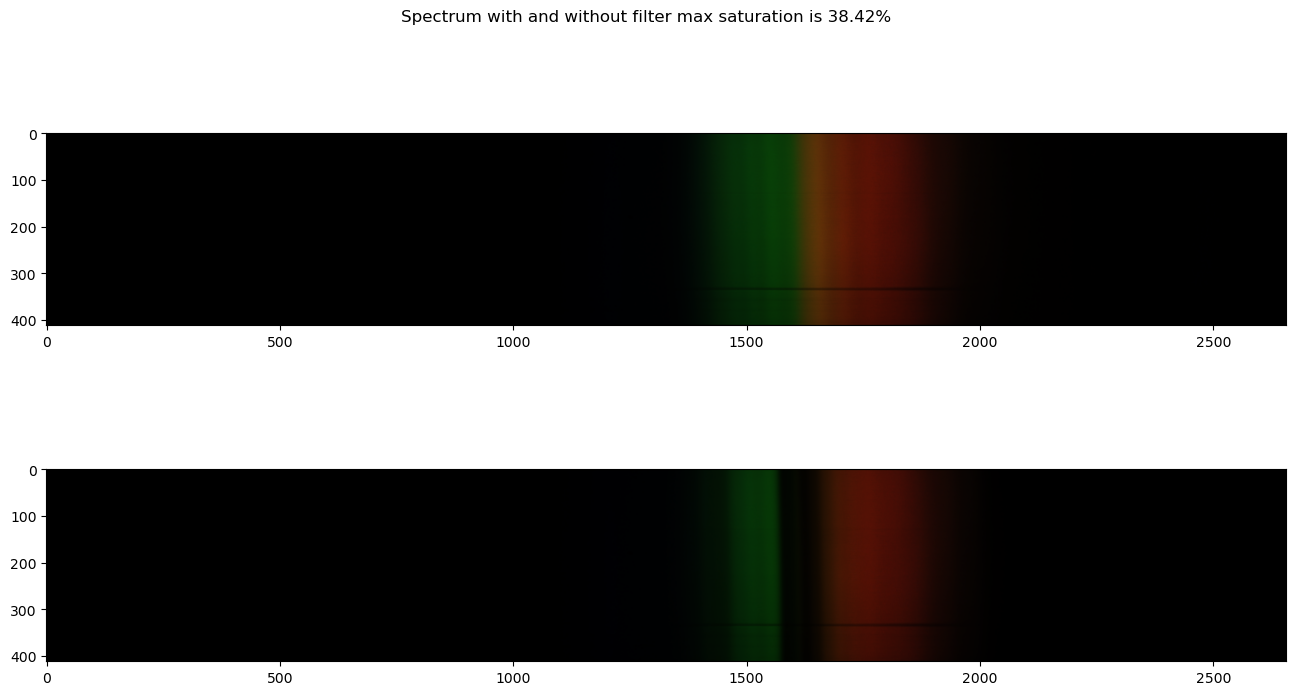

In [17]:
# Some Plotting

# The images were taken at infinite distance from the source (really short for this lens ) as the lens spectroscope combination is 
# set to infinite distance to measure the sky spectrum
# The source is a LUCIDE 49032/05/63 fillament lamp (LUCIDE G95) LED lamp 2200 K, with a makeshift light diffuser (bubble wrap)

fig = plt.figure(figsize=(16,8))
axes = fig.subplots(nrows=2, ncols=1)
im = axes[0].imshow(cv.convertScaleAbs(im_dat_nf, alpha=(255.0/65535.0)),vmin=0, vmax=2^16)
#cbar = axes[0].figure.colorbar(im, ax=axes[0])
#cbar.ax.set_ylabel('', rotation=-90, va="bottom")
axes[1].imshow(cv.convertScaleAbs(im_dat_wf, alpha=(255.0/65535.0)),vmin=0, vmax=2^16)
fig.suptitle('Spectrum with and without filter max saturation is {:.5}%'.format(np.max(im_dat_nf).astype(np.float64)/2**16*100))
fig.show()

In [18]:
#Compute transmission curve of combined effects lens+filter+spectral response of sensor
rgb_y, rgb_std = compute_rel_change(im_dat_nf,im_dat_wf,noprint=True)

/home/felix/KID_scripts/Spectroscope/calibrate.py:615: RuntimeWarning: divide by zero encountered in true_divide
  rgb = [(wf_data/nf_data)[::,::,i] for i in range(0,3)]
/home/felix/KID_scripts/Spectroscope/calibrate.py:615: RuntimeWarning: invalid value encountered in true_divide
  rgb = [(wf_data/nf_data)[::,::,i] for i in range(0,3)]


0  average std  0.15624436130849573
1  average std  0.19500799233693872
2  average std  0.18560713542171292


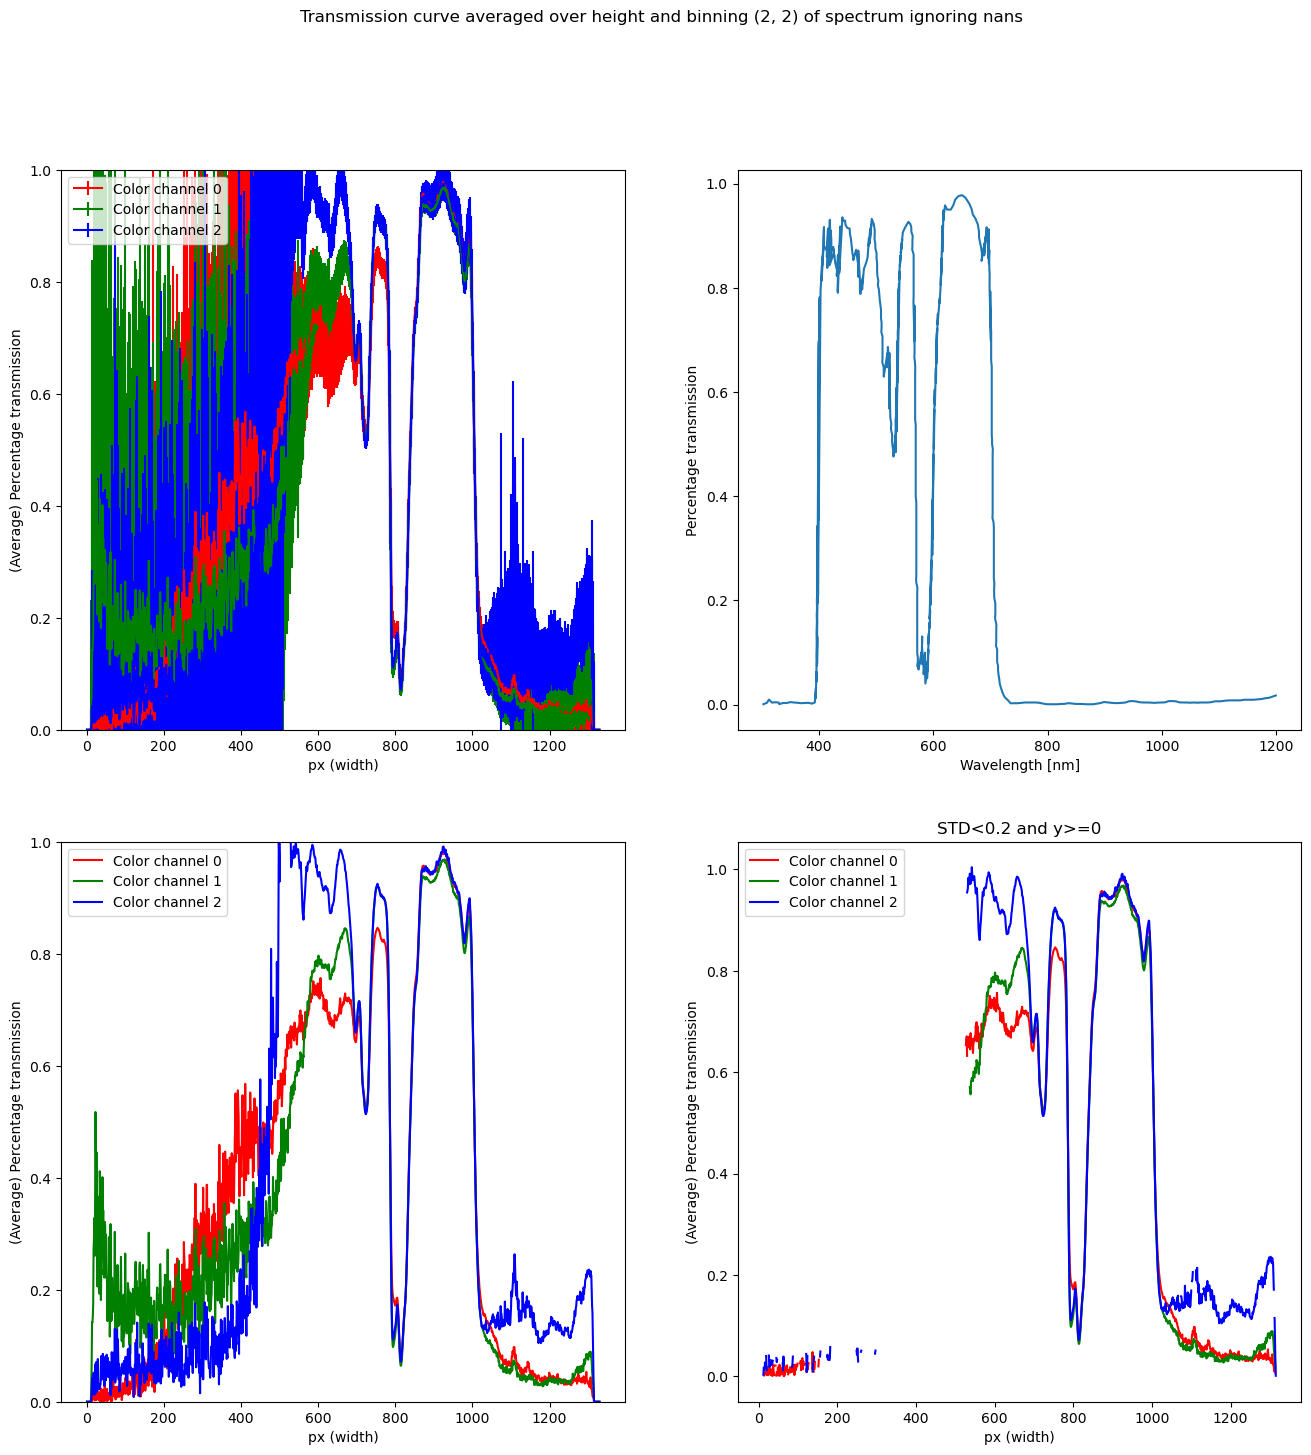

In [19]:
# Plotting
fig = plt.figure(figsize=(16,16))
axes = fig.subplots(nrows=2, ncols=2)

colors = {0:'Red', 1:'Green',2:'Blue'}
# 2,2 binning to achieve effectie pixel
binning = (2,2)
fig.suptitle('Transmission curve averaged over height and binning {} of spectrum ignoring nans'.format(binning))
for i in range(0,3):
    axes[1][0].plot(np.linspace(1,len(rgb_y[i]),len(rgb_y[i])),rgb_y[i],c=colors[i],label='Color channel {}'.format(i))
    axes[0][0].errorbar(np.linspace(1,len(rgb_y[i]),len(rgb_y[i])),rgb_y[i],c=colors[i],yerr=rgb_std[i],label='Color channel {}'.format(i))
    rgb_y[i][rgb_std[i]>0.2] = np.nan
    rgb_y[i][rgb_y[i]<=0] = np.nan
    axes[1][1].plot(np.linspace(1,len(rgb_y[i]),len(rgb_y[i])),rgb_y[i],c=colors[i],label='Color channel {}'.format(i))
    print(i, ' average std ', np.nanmean(rgb_std[i]))
    
# Expected: Note that the x-scale will be wrong here just to get approximate ideas
baader_filter = get_baader_response()
axes[0][0].set_xlabel('px (width)')
axes[0][0].set_ylabel('(Average) Percentage transmission')
axes[1][0].set_xlabel('px (width)')
axes[1][0].set_ylabel('(Average) Percentage transmission')
axes[1][1].set_xlabel('px (width)')
axes[1][1].set_ylabel('(Average) Percentage transmission')
axes[1][1].set_title('STD<0.2 and y>=0')

axes[0][1].plot(baader_filter[0],baader_filter[1])
axes[0][1].set_xlabel('Wavelength [nm]')
axes[0][1].set_ylabel('Percentage transmission')
axes[0][0].legend()
axes[0][0].set_ylim(0,1)
axes[1][0].set_ylim(0,1)
axes[1][0].legend()
axes[1][1].legend()


plt.show()

9477645 values negative after bias for 650nm.npy
1703826 of which in region of interest 650nm.npy
9442643 values negative after lens correction for 650nm.npy
1687968 of which in region of interest 650nm.npy
9430840 values negative after rotation for 650nm.npy
1670407 of which in region of interest 650nm.npy
Setting negatives to 0
changing back to uint16
Px count above 90% exposure is 0.0
(1329,)


924

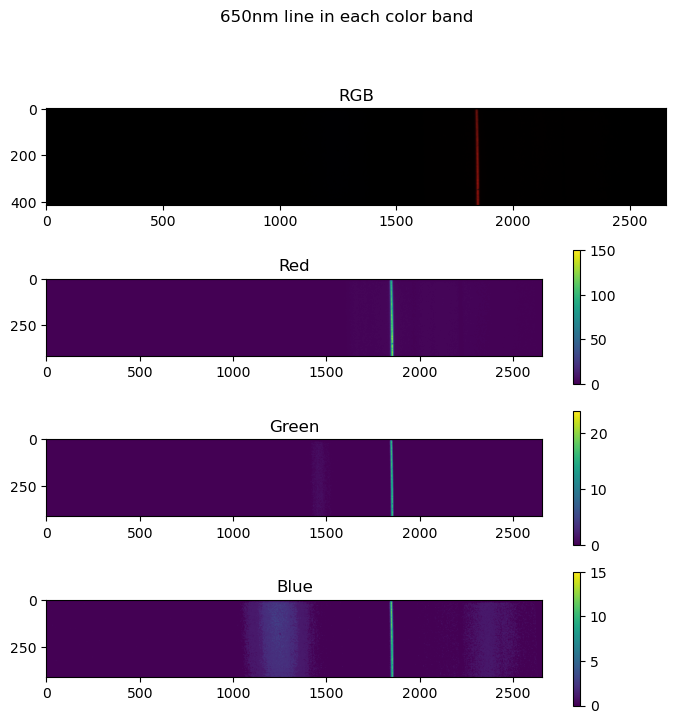

In [20]:
# Load, preprocess 650 nm line image and retrieve 650nm location
nm_650 = cal.process_image_with_calibration('./cal_images/650nm.npy')
colors = {0:'Red', 1:'Green',2:'Blue'}

fig = plt.figure(figsize=(8,8))
axes = fig.subplots(nrows=4, ncols=1)
fig.suptitle('650nm line in each color band')
axes[0].imshow(cv.convertScaleAbs(nm_650, alpha=(255.0/65535.0)))
axes[0].set_title('RGB')
for i in range(0,3):
    im=axes[i+1].imshow(cv.convertScaleAbs(nm_650[::,::,i], alpha=(255.0/65535.0)))
    cbar = axes[i+1].figure.colorbar(im, ax=axes[i+1])
    cbar.ax.set_ylabel('', rotation=-90, va="bottom")
    axes[i+1].set_title(colors[i])

# Find max vertical average in red band
bined = skimage.measure.block_reduce(nm_650[::,::,0], block_size=binning,func=np.mean,cval=0)
mean = np.mean(bined,axis=0)
print(mean.shape)
# Variable to store pixel location of 650nm  # TODO: Is binnign 0 or 1 horizontal?
px_650nm = np.where(mean == np.max(mean))[0][0]
px_650nm

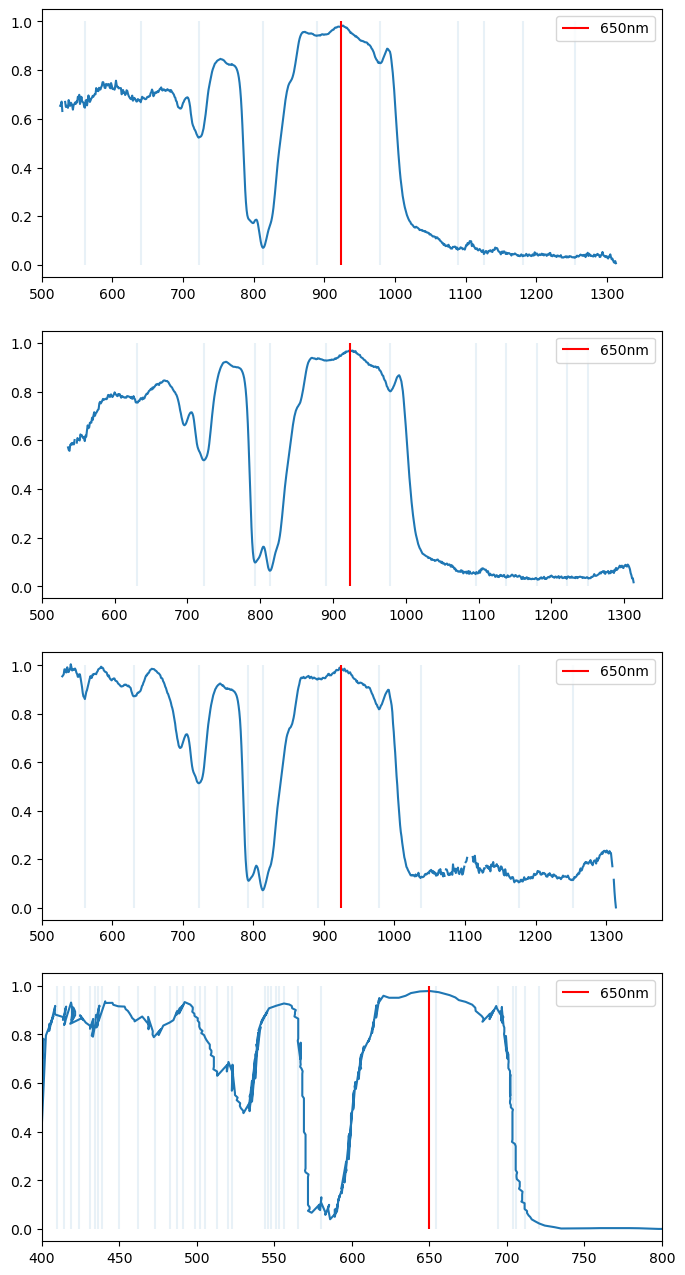

In [15]:
# Line identification done by hand as writing code for it prooved very dificult
fig = plt.figure(figsize=(8,16))
axes = fig.subplots(nrows=4, ncols=1)
for i in range(0,3):
    axes[i].vlines(scipy.signal.argrelextrema(rgb_y[i],np.less,order=15),0,1,alpha=0.1)
    axes[i].plot(np.linspace(0,len(rgb_y[i])-1,len(rgb_y[i])),rgb_y[i])
    axes[i].set_xlim(500)
    axes[i].vlines(px_650nm, 0,1,color='red',label='650nm')
    axes[i].legend()

axes[3].plot(baader_filter[0],baader_filter[1])
axes[3].vlines(scipy.signal.argrelextrema(baader_filter[1],np.less,order=1),0,1,alpha=0.1)
axes[3].set_xlim(400,800)
axes[3].vlines(650, 0,1,color='red',label='650nm')
axes[3].legend()


In [16]:
# plotly to make identification easier
import plotly.graph_objects as go

f = go.FigureWidget([go.Scatter(x=baader_filter[0],y=baader_filter[1], mode='markers')])
f

FigureWidget({
    'data': [{'mode': 'markers',
              'type': 'scatter',
              'uid': 'dc4a7736-58d2-48e0-b9f1-6dbf8e2aae7f',
              'x': array([ 302.64032922,  308.84703116,  312.32427984, ..., 1187.28230453,
                          1193.56378601, 1198.79835391]),
              'y': array([0.0007571 , 0.00346902, 0.00968043, ..., 0.01314745, 0.01553458,
                          0.01752386])}],
    'layout': {'template': '...'}
})

In [21]:
# Misc function to help identify
scipy.signal.argrelextrema(rgb_y[0],np.greater,order=15)

(array([ 553,  586,  605,  669,  706,  753,  872,  926,  989, 1106, 1142,
        1198, 1220, 1273, 1294]),)

In [22]:
# Written out known wavelengths and px data with some code to check its good and poly fit to determine mapping
# Create dicts with key px : value
ident = {561: 430, 706 :520,753:555,872:620,989:695, 793:575, 813:586, 979:685, 650: 472 , 722: 530.1, 979:685}

import collections
from tabulate import tabulate
ident[px_650nm] = 650
ident = collections.OrderedDict(sorted(ident.items()))
found=False
if np.sum(np.diff(np.array([key for key in ident]))<0) != 0 or np.sum(np.diff(np.array([ident[key] for key in ident]))<0) != 0:
    px_diff = np.diff(np.array([key for key in ident]),prepend=0)
    lambda_dif = np.diff(np.array([ident[key] for key in ident]),prepend=0)
    px = [key for key in ident]
    lam = [ident[key] for key in ident]

    print(tabulate([[px[i], px_diff[i],lam[i],lambda_dif[i]]for i in range(len(ls))],headers=['px','px_diff','lambda','lambda_diff']))
    raise Exception('Provided data not increasing')
poly = []
for i in range(3,100):
    # Now we create the poly fit
    coeffs = np.polyfit([key for key in ident], [ident[key] for key in ident],i)
    # And create the wavelengths corresponding to the px location
    px_wavelengths = np.polyval(coeffs,np.linspace(0,len(rgb_y[0])-1,len(rgb_y[0])))
    if np.sum(np.diff(px_wavelengths)<0) == 0:
        print('found monotonically increasing polynomial function')
        print(i)
        found=True
        order = i
        print("Coefficients: (Add to calib file)")
        print(coeffs)
        break
    poly.append(np.sum(np.diff(px_wavelengths)<0))
if not found:
    poly = np.array(poly)
    order = np.where(poly==poly.min())
    print(order)
    coeffs = np.polyfit([key for key in ident], [ident[key] for key in ident],order[0][0])
    # And create the wavelengths corresponding to the px location
    px_wavelengths = np.polyval(coeffs,np.linspace(0,len(rgb_y[0])-1,len(rgb_y[0])))
    print(coeffs)

found monotonically increasing polynomial function
3
Coefficients: (Add to calib file)
[-3.53463634e-07  7.57740053e-04  9.68022810e-02  1.96536671e+02]


## First estimate

the coeffs need to be added to the calib attribute of the calibration class to extract observed spectra 

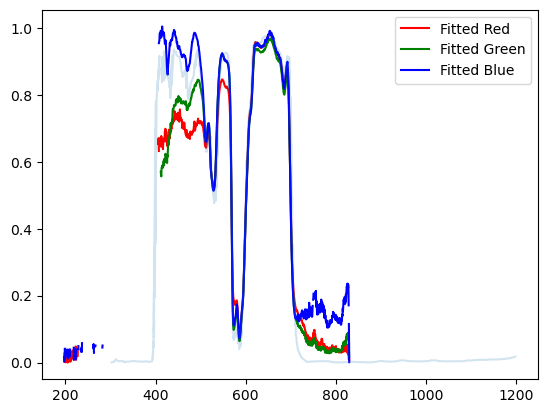

In [69]:
colors = {0:'Red', 1:'Green',2:'Blue'}

for i in range(0,3):
    plt.plot(px_wavelengths,rgb_y[i],c=colors[i],label='Fitted {}'.format(colors[i]))
plt.plot(baader_filter[0],baader_filter[1],alpha=0.2)
#plt.scatter(spec_range,response_red,marker='.',c='red')
#plt.scatter(spec_range,response_green,marker='.',c='green')
#plt.scatter(spec_range,response_blue,marker='.',c='blue')

plt.legend()

## The second diffraction spectrum is starting to interact with nir around 800, its also possible that at 200 the first diffraction spectrum is interacting so need to isolate that

TODO: Use geometric equations for first second etc diffraction patterns and see if i can map them on the found wavelengths to find where the second is supposed to go

Might be able to use that to refine the first guess 

Otherwise: Use UV light to find where blue restarts not sure if i can use this as blue seems practically continuous, use flame (hopefully its got some nir or find something that does) 



## Calibration against solar spectrum

### In complete first need to find where the second and zeroth order diffraction patterns start

In [74]:
preprocess_images(img_dir='./cal_images/sun/',out_img='./cal_images/sun.npy')

In [4]:
lambd,intens = cal.process_spectrum('./cal_images/sun.npy')
measured_solar = [lambd,intens]
exp = 0.1 # [s]
specrtoscope_opening_radius = 1.40 # pm 0.05 --> 3.6% [mm]
# FIXME: I dont actually know if all light of the opening is propagated to the diffraction grating but fitting should fix this
# Might be able to just leave it in per unit opening
measured_solar[1] = measured_solar[1]/exp/(4*np.pi*specrtoscope_opening_radius**2) # Count/s /[sensor size]


79323 values negative after bias for sun.npy
1758 of which in region of interest sun.npy
72326 values negative after lens correction for sun.npy
475 of which in region of interest sun.npy
70785 values negative after rotation for sun.npy
249 of which in region of interest sun.npy
Setting negatives to 0
changing back to uint16
Px count above 90% exposure is 5.072


In [5]:
sol_spect = get_solar_spectrum()
sol_spect = [sol_spect[::,0],sol_spect[::,1]]

Text(0, 0.5, 'Photons $\\ s^{-1}\\ cm^{-2}$')

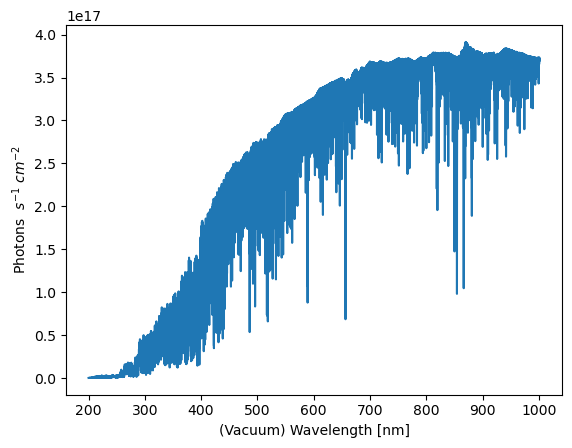

In [6]:
plt.plot(sol_spect[0],sol_spect[1])
plt.xlabel('(Vacuum) Wavelength [nm]')
plt.ylabel(r'Photons $\ s^{-1}\ cm^{-2}$')

Text(0.5, 1.0, 'Rebined to wavlengths of measurements')

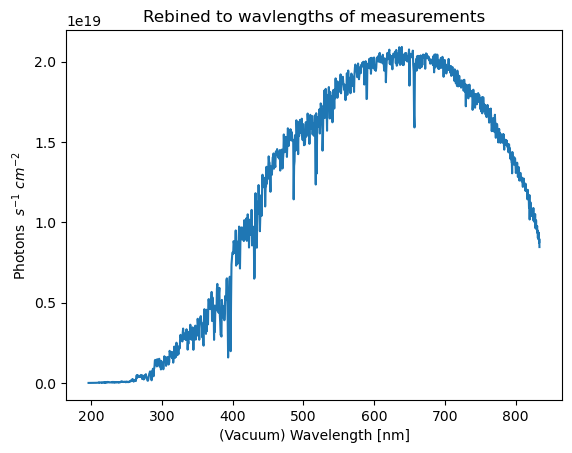

In [7]:
# Bin solar spec into wavlength range of measured data
sol_spect_bin = bin_spectrum(sol_spect,measured_solar[0])
sol_spect_bin = [measured_solar[0],sol_spect_bin]

plt.plot(*sol_spect_bin)
plt.xlabel('(Vacuum) Wavelength [nm]')
plt.ylabel(r'Photons $\ s^{-1}\ cm^{-2}$')
plt.title('Rebined to wavlengths of measurements')

Text(0.5, 0, 'Wavelength [nm]')

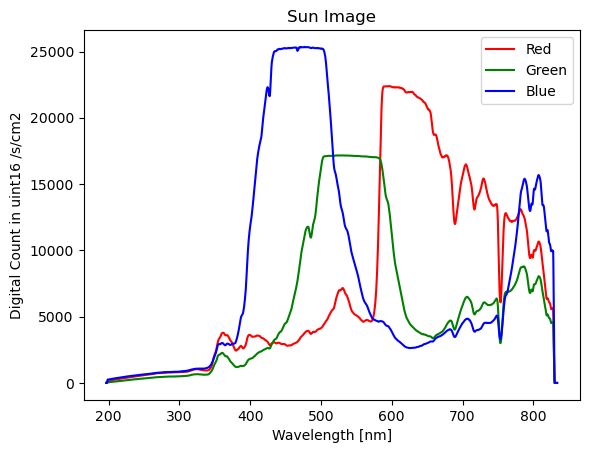

In [140]:
for i in range(0,3):
    plt.plot(measured_solar[0], measured_solar[1][::,i],label=colors[i],c=colors[i])
plt.title('Sun Image') # FIXME: I think debayering is fucking with green
# FIXME: See that blue peak in 800, thats the second diffraction pattern
plt.legend()
plt.ylabel('Digital Count in uint16 /s/cm2')
plt.xlabel('Wavelength [nm]')

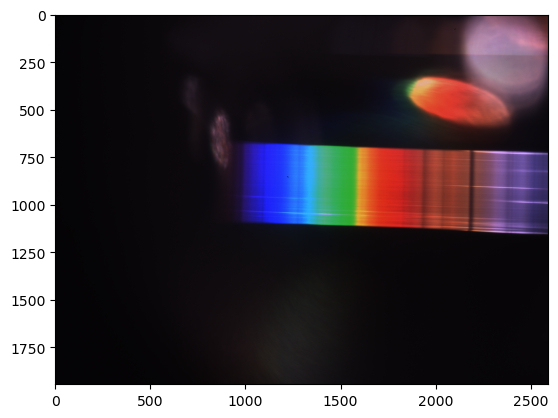

In [141]:
# And the corresponding image

plt.imshow(cv.convertScaleAbs(np.load('./cal_images/sun.npy'), alpha=(255.0/65535.0)))


# DC to irradiance

We know that photons count to DC is approximately linear per wavlength

There is no definite wavelength dependence that can be exploited due to the bayer matrix and generally unknown sensor and spectroscope properties

The Digital Count (DC) output is then related to the input spectrum as $DC[\lambda] = \phi_{\photon}(\lambda) * QE$ 

So we will create a generic Quantum efficiency vector as a function of lambda for each color channel.

So essentially 3 polynomial fits that are added together to achieve the correct(-ish) flux 

In [145]:
measured_solar[1].shape

(1329, 3)

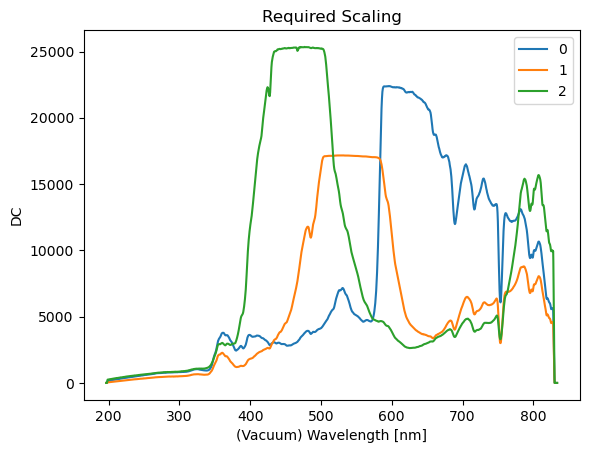

In [26]:
bin_spect = bin_spectrum(sol_spect, measured_solar[0])
plt.title('Required Scaling')
for i in range(0,3):
    plt.plot(measured_solar[0],measured_solar[1][::,i],label=str(i))
plt.xlabel('(Vacuum) Wavelength [nm]')
plt.ylabel(r'DC')
plt.legend()

/tmp/ipykernel_726527/3174319127.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(measured_solar[0][:-100:],(bin_spect/measured_solar[1][::,i]/measured_solar[0])[:-100:],label=str(i))
/tmp/ipykernel_726527/3174319127.py:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(measured_solar[0][:-100:],(bin_spect/measured_solar[1][::,i]/measured_solar[0])[:-100:],label=str(i))


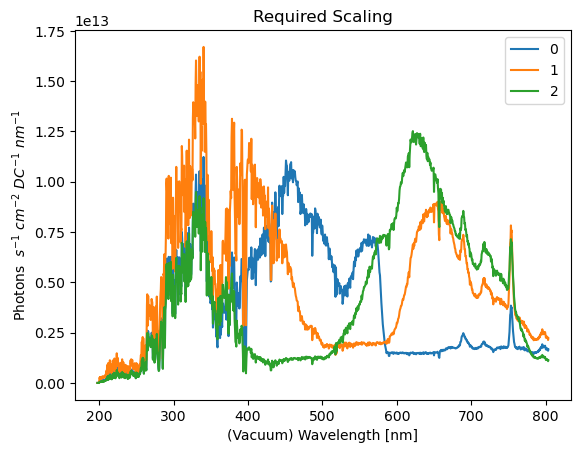

In [32]:
# We prebin and crop spectrum as the x doesnt change
bin_spect = bin_spectrum(sol_spect, measured_solar[0])
plt.title('Required Scaling')
for i in range(0,3):
    plt.plot(measured_solar[0][:-100:],(bin_spect/measured_solar[1][::,i]/measured_solar[0])[:-100:],label=str(i))
plt.xlabel('(Vacuum) Wavelength [nm]')
plt.ylabel(r'Photons $\ s^{-1}\ cm^{-2}\ DC^{-1}\ nm^{-1}$')
plt.legend()

In [35]:
# FIXME: Isolate second diffraction pattern using ir filter taken from sensor so that there is a strong gap between 1 and 2 
# Also use UV lamp to isolate start --> uv lamp isnt uv uv so it will be a bit to the right of the actual start --> could find ending in dark room and very hot object
# FIRE!!!!
# Could also use the known wavelengths to figure out grating size and distance 
# (know more than 3 wavleengths and sensor size enough to recover normal dist from ext sensor )

In [33]:
def y_optimization_function(poly_coeffs, solar_spectrum, measured_spectrum):
    """
    This will optimize the polynomial relative intensities

    Poly_coeffs = list of lists where low order lsit contains poly coeffs for individual color 
    solar_spectrum = solar spectrum data
    measured_spectrum = solar spectrum measured data
    order = polynomial order being fitted

    TODO: Poly may not be the right choice, possibly specifying a coeff for each px would be better
    """
    # Reshape coefficients
    # So that first array is red, first poly: y scaling, second poly: lambda dependent scaling, etc 
    poly_coeffs = np.reshape(poly_coeffs, (len(poly_coeffs)//4, 4))
    # Compute poly and sum components, such that one is left with the estimate of the photon flux, first poly y scale, second wavelength dep
    # FIXME: Properly think about what will produce above graph random linear poly approach wont work
    scaled_spectrum = np.sum(np.array([poly_coeffs[i][0]*measured_spectrum[1][::,i]* # Linear scaling for each color * poly wavelngth dependence
                                       np.polyval(poly_coeffs[i][1::],measured_spectrum[0]) for i in range(0,3)]),axis=0)
    # Return mean difference of scaled spectrum and expected spectrum
    return np.abs(np.mean(solar_spectrum-scaled_spectrum))

order = 3
#### Change workers to something reasonable on your cpu, with 20 workers max iter takes approx 15s
res = scipy.optimize.differential_evolution(y_optimization_function,bounds=[(0,1e12)]+[(0,1)]*3*order,workers=20, 
                                            recombination=0.7, mutation=(1, 1.9),x0 = [1]*3*(order+1), args=(bin_spect, measured_solar))
res


/home/felix/miniconda3/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:377: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


ValueError: operands could not be broadcast together with shapes (12,) (10,) 

In [ ]:
res

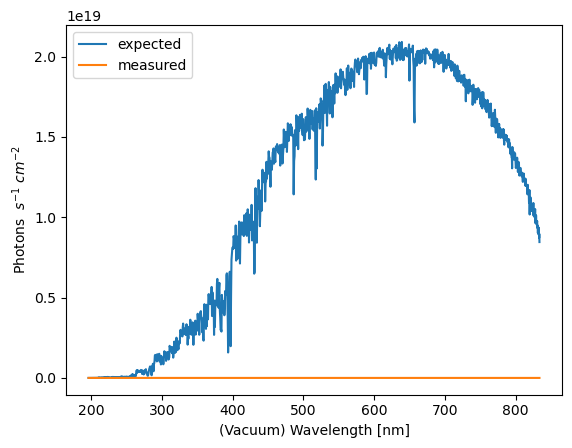

In [21]:
poly = np.reshape(res.x,(res.x.size//3, 3))
scaled_solar = np.sum(np.array([np.polyval(poly[i],measured_solar[1][::,i]) for i in range(0,3)]),axis=0)
plt.plot(measured_solar[0],bin_spect,label='expected')
plt.plot(measured_solar[0],scaled_solar,label='measured')
plt.xlabel('(Vacuum) Wavelength [nm]')
plt.ylabel(r'Photons $\ s^{-1}\ cm^{-2}$')
plt.legend()

## How Digital Count (DC) behaves as a function of \lambda and photon count

A small argument to get clear on how to procede

https://micro.magnet.fsu.edu/primer/digitalimaging/cmosimagesensors.html

 In effect, the number of electrons produced is a function of the wavelength and the intensity of light striking the semiconductor.

then they are either converted into a voltage

There are two basic photosensitive pixel element architectures utilized in modern CMOS image sensors: photodiodes and photogates (see Figure 6). In general, photodiode designs are more sensitive to visible light, especially in the short-wavelength (blue) region of the spectrum. Photogate devices usually have larger pixel areas, but a lower fill factor and much poorer blue light response (and general quantum efficiency) than photodiodes. However, photogates often reach higher charge-to-voltage conversion gain levels and can easily be utilized to perform correlated double sampling to achieve frame differencing.


Ov5647 datasheet: https://www.datasheets.com/en/part-details/ov5647-omnivision-technologies-416673353
- whats automatic band filter (ABF)
- what is automatic 50/60 Hz luminance detection
- support for black sun cancellation --> overexposed turns black -- see if thats already on -> should be



How to correct for spillover


CMOS can operate as current or votage readout 

$V_{out} = V_{photo}-V_{th}-\sqrt{\frac{2I_{Bias}}{k_n \frac{W}{L}}}$


electrons to voltage ~ linear

photons to electrons -> pre microlens : fresnel equation : gives quantum efficiency --> linear conversion (with QE being non linear)
 -> post microlens interal quantum efficiency : linear (again qe nonlinear) so in total

 (Photon flux) * (Integration period) * QE_external *QE_Internal * A/C_sense * ADC_conversion = photons/adu

where gain is e-/adu

Total relation linear with nonlinear in lambda

We have the sensitivity of the sensor 600mV/lux/sec, where a lux is a lumen per square meter or cd sr m^-2, now a candela is teh luminous power per unit solid angle



### Lens Chief Ray Angle (CRA)

The graph describes how the microlenses on each pixel shift as a function moving away from the center of the image. The chief ray is an off axis ray passing through the center of the lens


## Second Diffraction peak

Calibrate with UV lamp 

Does it overlap with the orginal peak? 

Can figure out where it does since we have the polyomial --> Reshape fit as taylor expansion


## Random thought

using the overlap of the color bands a known spectrum for the central wavelength and the wavelength dependent response, and HDR imaging we can most likely achieve a sub RGB color binning 

## Lensless focusing using microlenses
pixel size: 1.4 μm x 1.4 μm

https://web.stanford.edu/~wandell/data/papers/CMOSRoadmap-2005-SPIE.pdf 

THe offset $\Delta$ for the microlenses for proper light focusing can be described as:

$\Delta = f_{ML}*tan(\theta_{CRA})$

TODO: No idea if this will work -> give it a try next time the casing gets updated


# OV 5647 Product info 
https://www.alldatasheet.com/datasheet-pdf/pdf/587045/OMNIVISION/OV5647.html

max S/N : 34dB

sensitivity: 600mV/lux/sec

dark current: 8mV/s @ 50C junction Temperature

# Some HDR trials

# FIXME: Is camera response the same as spectral response???




In [2]:
%load_ext autoreload
%autoreload 2
from calibrate import *

In [52]:
make_hdr('./cal_images/HDR_No_filter')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


37.30451290387529

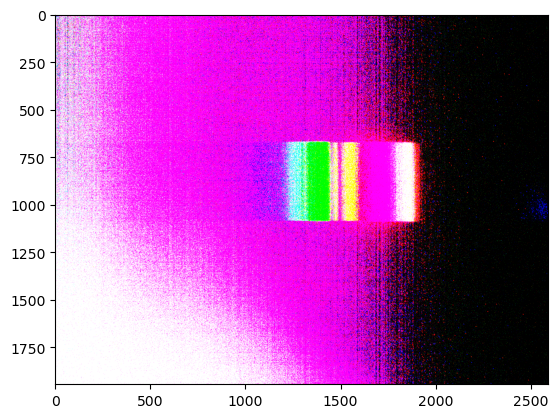

In [54]:
fin = '/home/felix/KID_scripts/Spectroscope/cal_images/HDR_No_filter/hdr'
im_list = os.listdir(fin)
import matplotlib.pyplot as plt

plt.imshow(np.load(os.path.join('/home/felix/KID_scripts/Spectroscope/cal_images/HDR_Filter/hdr',im_list[-1])))
np.mean(np.load(os.path.join('/home/felix/KID_scripts/Spectroscope/cal_images/HDR_Filter/hdr',im_list[-1])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


57.69186982156773

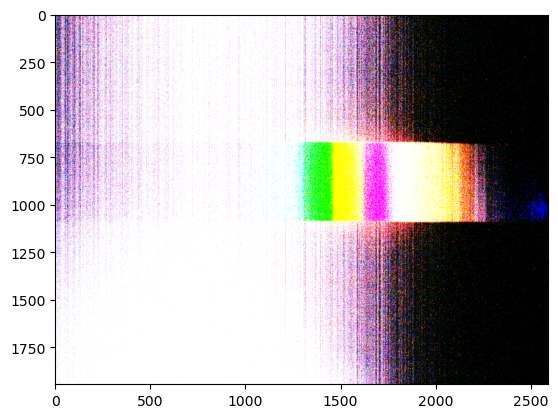

In [55]:
plt.imshow(np.load('/home/felix/KID_scripts/Spectroscope/cal_images/HDR_No_filter/hdr/1064891.npy'))
np.mean(np.load('/home/felix/KID_scripts/Spectroscope/cal_images/HDR_No_filter/hdr/1064891.npy'))